In [117]:
# importing basic library to wrangle and explore the data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# from pandas_profiling import ProfileReport
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

### Importing price series

In [118]:
# impoting the data
path = '/Users/marciobernardo/Documents/Springboard/Projects/3rd Capstone project/dados/'


df_bra_basis = pd.read_csv(path+'bra_basis.csv', index_col='date', parse_dates=['date']) 

                            

The p-value obtained from the ADF stationarity test for the Brazilian coffee basis series was low, indicating a failure to reject the null hypothesis of stationarity. We will proceed to difference the series to achieve stationarity in all the coffee time series. This step will enable us to utilize multivariate models in the basis risk analysis.

In [119]:
df_bra_basis_diff = df_bra_basis.diff().dropna()

# Saving the basis diff dataframe to a csv file
df_bra_basis_diff.to_csv(path + 'bra_basis_diff.csv', index_label='date')

Visual inspection of the differatiated series

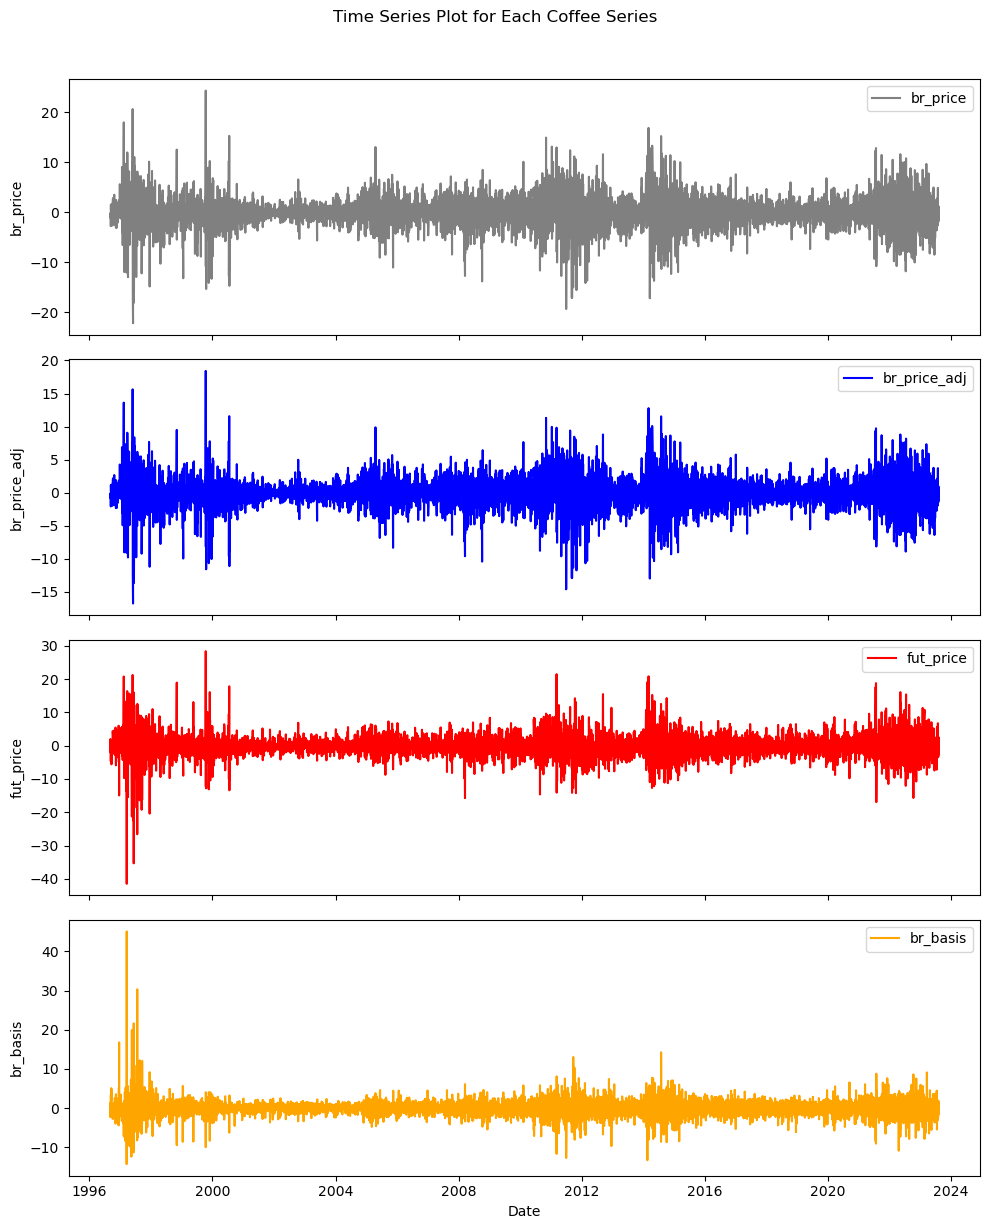

In [120]:
# Create subplots for each column
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
clr_list = ['grey', 'blue', 'red', 'orange']

# Plot each column in a separate subplot
for i, column in enumerate(df_bra_basis_diff.columns):
    axs[i].plot(df_bra_basis_diff.index, df_bra_basis_diff[column], label=column, color=clr_list[i])
    axs[i].set_ylabel(column)
    axs[i].legend()

# Set the common x-axis label and title
axs[-1].set_xlabel('Date')
plt.suptitle('Time Series Plot for Each Coffee Series', y=1.02)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [121]:
df_bra_basis_diff.describe()

,br_price,br_price_adj,fut_price,br_basis
count,6514.000000,6514.000000,6514.000000,6514.000000
mean,0.008474,0.006406,0.005573,0.000834
std,3.093931,2.338975,3.367396,2.131505
min,-22.210000,-16.790498,-41.500000,-14.293563
25%,-1.360000,-1.028144,-1.487500,-0.914110
50%,0.020000,0.015120,0.000000,0.017665
75%,1.410000,1.065943,1.400000,0.945678
max,24.370000,18.423432,28.400000,45.106064


In [122]:
df_bra_basis_diff.corr()

,br_price,br_price_adj,fut_price,br_basis
br_price,1.000000,1.000000,0.778723,-0.132908
br_price_adj,1.000000,1.000000,0.778723,-0.132908
fut_price,0.778723,0.778723,1.000000,-0.725300
br_basis,-0.132908,-0.132908,-0.725300,1.000000


It is interesting to note that while the coffee future price is significantly positively correlated with the spot Brazilian coffee price, its correlation with Basis risk is negative, as expected (basis = spot - future). However, the correlation level is lower, approximately 0.73, compared to the correlation between the future price and Brazilian spot coffee, which is around 0.79. This difference could be attributed to an exchange rate effect. Therefore, the exchange rate also affects the basis risk.

Calculating and saving the USD/BRL exchange rate for the period.

In [124]:
df = pd.read_csv(path + 'coffee_brazil.csv')

In [125]:
df.head()

,Data,À vista R$,À vista US$
0,02/09/1996,123.09,121.15
1,03/09/1996,119.68,117.69
2,04/09/1996,119.39,117.44
3,05/09/1996,118.42,116.38
4,06/09/1996,118.09,115.98


In [126]:
# Calculating the exchange rate
df['fx'] = df['À vista R$']/df['À vista US$']
df_fx = df[['Data','fx']]

del(df)

In [127]:
df_fx.head()

,Data,fx
0,02/09/1996,1.016013
1,03/09/1996,1.016909
2,04/09/1996,1.016604
3,05/09/1996,1.017529
4,06/09/1996,1.018193


In [128]:
# Creating a new dataframe with the FX rate and setting a datetime index.
df_fx.columns = ['date','fx']

df_fx.loc[:,'date'] = pd.to_datetime(df_fx['date'], format='%d/%m/%Y')

df_fx.set_index('date', inplace=True)

In [129]:
df = pd.merge(df_bra_basis, df_fx, left_index=True, right_index=True, how='inner')

In [130]:
# Saving the data frame we will be modeling
df.to_csv(path + 'df.csv', index_label='date')

In [ ]:
df_fx_diff = df_fx.diff().dropna()

In [ ]:
df_fx_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6705 entries, 1996-09-03 to 2023-08-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fx      6705 non-null   float64
dtypes: float64(1)
memory usage: 104.8 KB


Incorporating the Brazilian real and US dollar exchange rate to the basis series    

In [ ]:
df_diff = pd.merge(df_bra_basis_diff, df_fx_diff, left_index=True, right_index=True, how='inner')

In [ ]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6514 entries, 1996-09-04 to 2023-08-08
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   br_price      6514 non-null   float64
 1   br_price_adj  6514 non-null   float64
 2   fut_price     6514 non-null   float64
 3   br_basis      6514 non-null   float64
 4   fx            6514 non-null   float64
dtypes: float64(5)
memory usage: 305.3 KB


In [ ]:
# Saving the data frame we will be modeling
df_diff.to_csv(path + 'df_diff.csv', index_label='date')

### ARIMA model

We will start by modeling the differentiated series on a ARIMA (2,1,1) model.

In [131]:
df_bra_basis.columns

Index(['br_price', 'br_price_adj', 'fut_price', 'br_basis'], dtype='object')

In [132]:
arma_br_model = ARIMA(df_bra_basis['br_price'], order=(2,1,1))

/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [133]:
arma_br_adj_model = ARIMA(df_bra_basis['br_price_adj'], order=(2,1,1))

/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [134]:
arma_fut_model = ARIMA(df_bra_basis['fut_price'], order=(2,1,1))

/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [135]:
arma_br_basis_model = ARIMA(df_bra_basis['br_basis'], order=(2,1,1))


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [136]:
# Fitting the ARMA (2,1) models
results_br_model = arma_br_model.fit()
results_br_adj_model = arma_br_adj_model.fit()
results_fut_model = arma_fut_model.fit()
results_br_basis_model = arma_br_basis_model.fit()


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA models results

In [137]:
print(results_br_model.summary())

                               SARIMAX Results                                
Dep. Variable:               br_price   No. Observations:                 6515
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -16582.829
Date:                Sun, 26 Nov 2023   AIC                          33173.657
Time:                        07:49:05   BIC                          33200.784
Sample:                             0   HQIC                         33183.039
                               - 6515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4683      0.094     -4.966      0.000      -0.653      -0.284
ar.L2         -0.0703      0.008     -8.752      0.000      -0.086      -0.055
ma.L1          0.4508      0.095      4.732      0.0

In [138]:
print(results_br_adj_model.summary())

                               SARIMAX Results                                
Dep. Variable:           br_price_adj   No. Observations:                 6515
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -14760.671
Date:                Sun, 26 Nov 2023   AIC                          29529.341
Time:                        07:49:24   BIC                          29556.468
Sample:                             0   HQIC                         29538.722
                               - 6515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4682      0.094     -4.963      0.000      -0.653      -0.283
ar.L2         -0.0703      0.008     -8.752      0.000      -0.086      -0.055
ma.L1          0.4506      0.095      4.729      0.0

In [139]:
print(results_fut_model.summary())

                               SARIMAX Results                                
Dep. Variable:              fut_price   No. Observations:                 6515
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -17137.777
Date:                Sun, 26 Nov 2023   AIC                          34283.554
Time:                        07:49:41   BIC                          34310.681
Sample:                             0   HQIC                         34292.935
                               - 6515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4491      0.092     -4.883      0.000      -0.629      -0.269
ar.L2         -0.0631      0.007     -8.679      0.000      -0.077      -0.049
ma.L1          0.4350      0.093      4.696      0.0

In [140]:
print(results_br_basis_model.summary())

                               SARIMAX Results                                
Dep. Variable:               br_basis   No. Observations:                 6515
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -14093.851
Date:                Sun, 26 Nov 2023   AIC                          28195.703
Time:                        07:49:49   BIC                          28222.830
Sample:                             0   HQIC                         28205.084
                               - 6515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8715      0.006    145.086      0.000       0.860       0.883
ar.L2          0.0949      0.006     15.977      0.000       0.083       0.107
ma.L1         -0.9963      0.001   -795.689      0.0

All ARMA models have significantly different than zero paramentes. The coffee series have negative AR parameters and positive MA parameters, while the basis series have the opposit (negative AR parameters and positive MA). The variance paramentes (sigma2) is lower for the basis series, this results is reproduces in the standard deviation analises of the series. And in accordance to the expectation that basis risk is significantly lower that price risk.

Forecasting the coffee basis series with ARIMA model.

In [141]:
# In sample predictions 
br_basis_forecast = results_br_basis_model.get_prediction(start=-90)

# forecast mean
mean_br_basis_forecast = br_basis_forecast.predicted_mean

# Condifence intervals of the forecast
confidence_interbals_basis_forecast = br_basis_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_interbals_basis_forecast.loc[:,'lower br_basis']
upper_limits = confidence_interbals_basis_forecast.loc[:,'upper br_basis']

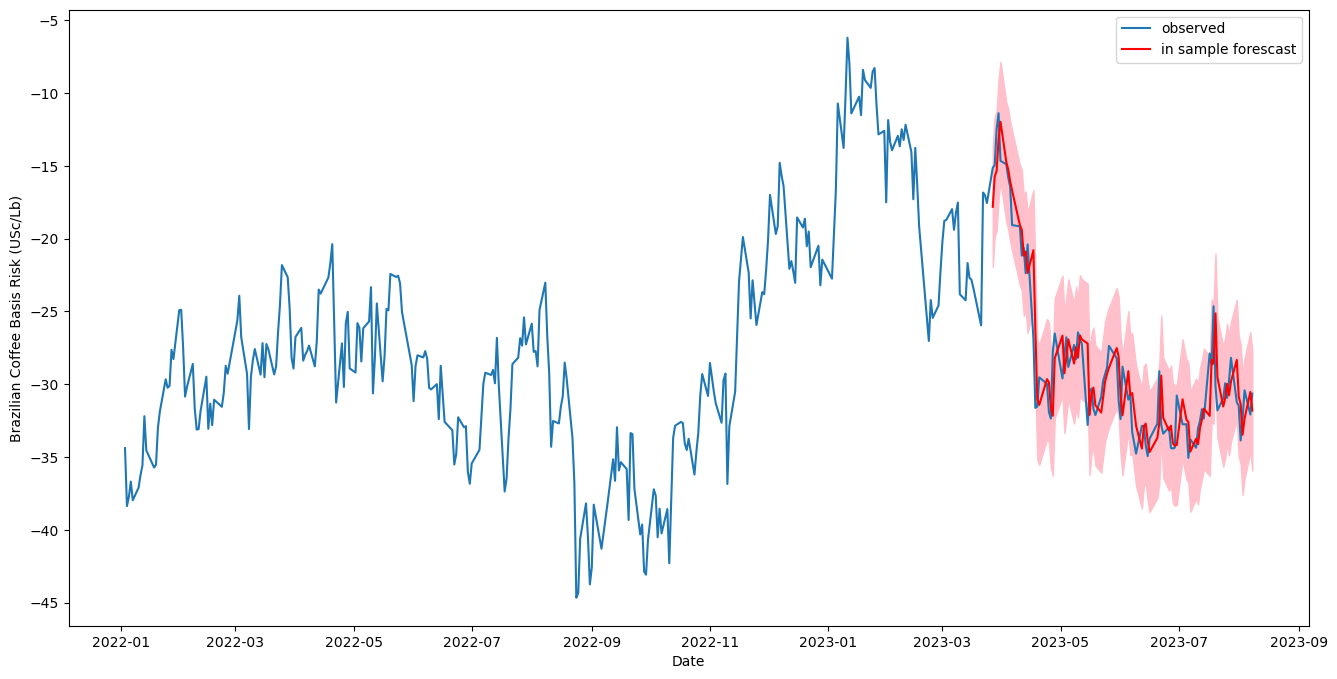

In [143]:
df_bra_basis_2022 = df_bra_basis[df_bra_basis.index.year >= 2022]

plt.figure(figsize=(16,8))

plt.plot(df_bra_basis_2022.index,
         df_bra_basis_2022['br_basis'],
         label = 'observed')
# Plot in sample prediction

plt.plot(mean_br_basis_forecast.index,
         mean_br_basis_forecast,
         color = 'red',
         label='in sample forescast')

# Plot Confidence interval
plt.fill_between(lower_limits.index, lower_limits,
		 upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('Brazilian Coffee Basis Risk (USc/Lb)')
plt.legend()
plt.show();

The untrained ARIMA(2,1,1) in-sample model exhibit reasonable predictive performance, but has large confidence intervals. To generate an effective out of sample model, we will carefully consider seasonality, incorporate exogenous variables such as exchange rate, and optimize the model parameters.

Training and Testing data set

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6515 entries, 1996-09-03 to 2023-08-08
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   br_price      6515 non-null   float64
 1   br_price_adj  6515 non-null   float64
 2   fut_price     6515 non-null   float64
 3   br_basis      6515 non-null   float64
 4   fx            6515 non-null   float64
dtypes: float64(5)
memory usage: 305.4 KB


We will partition the data into training from 1996 to 2016 and testing from 2017 to 2023.

In [147]:
df_training = df[df.index.year <= 2016]
df_testing =  df[df.index.year >= 2017]

df_diff_training = df_diff[df_diff.index.year <= 2016]
df_diff_testing =  df_diff[df_diff.index.year >= 2017]

In [146]:
# saving the training and testing series

df_training.to_csv(path + 'df_training.csv', index_label='date')
df_testing.to_csv(path + 'df_testing.csv', index_label='date')
df_diff_training.to_csv(path + 'df_diff_training.csv', index_label='date')
df_diff_training.to_csv(path + 'df_diff_training.csv', index_label='date')